In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [4]:
df = pd.read_csv("combined_results.csv")

metric = "CRPS"
df = df[df["metric"] == metric]
df = df[df["value"] >= 0].copy()
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor',  'RandomForestRegressor', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN'
}

suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

Split 'gower_split': baseline CRPS per task:
 task_id
361093      0.021535
361094      0.549592
361096      0.060723
361097      3.969800
361098      0.012042
361099      0.294680
361101      0.200483
361102      0.119440
361103      0.201413
361104      0.042396
361287      0.013209
361288      1.113314
361289    233.140307
361291      1.572152
361292      0.300655
361293      1.116300
361294      0.145214
dtype: float64
Split 'gower_split': overall lowest CRPS = 0.0120424054999026



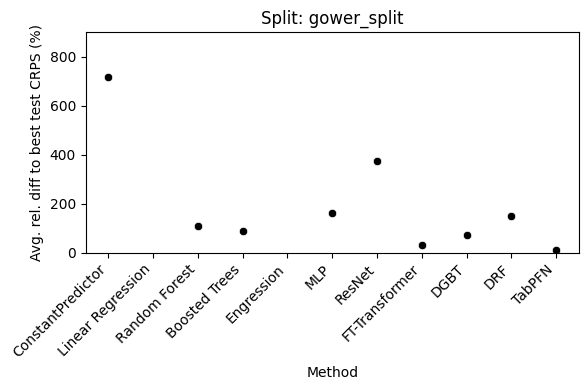

Split 'kmedoids_split': baseline CRPS per task:
 task_id
361093      0.024336
361094      0.805446
361096      0.059879
361097      4.039322
361098      0.013145
361099      0.264383
361101      0.160131
361102      0.086225
361103      0.217260
361104      0.006256
361287      0.012857
361288      1.143533
361289    227.409469
361291      1.549828
361292      0.295625
361293      1.065122
361294      0.104824
dtype: float64
Split 'kmedoids_split': overall lowest CRPS = 0.0062564449030772



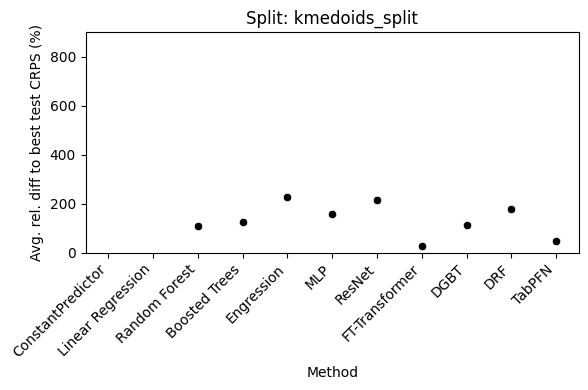

Split 'umap_split': baseline CRPS per task:
 task_id
361072      1.054257
361073      1.079076
361074      0.001054
361076      0.390128
361077      0.000082
361078      0.148570
361079      0.278895
361080      0.125802
361081      0.012498
361082      0.420943
361083      0.201972
361084      0.124743
361085      0.010586
361086      0.052272
361087      0.065257
361088      0.295254
361093      0.183040
361094      0.026021
361096      0.049050
361097      3.440862
361098      0.048229
361099      0.198028
361101      0.191507
361102      0.115659
361103      0.220216
361104      0.021007
361279      0.012295
361280      1.234835
361281      1.626420
361287      0.012080
361288      0.913870
361289    205.625645
361291      1.688195
361292      0.318549
361293      1.043999
361294      0.052272
dtype: float64
Split 'umap_split': overall lowest CRPS = 8.193873911473361e-05



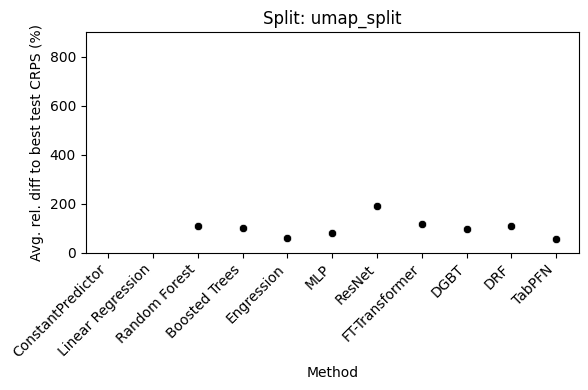

Split 'mahalanobis_split': baseline CRPS per task:
 task_id
361072    2.124565
361073    0.485057
361074    0.001281
361076    0.391615
361077    0.000115
361078    0.122197
361079    0.381959
361080    0.152763
361081    0.013340
361082    0.399360
361083    0.219504
361084    0.103047
361085    0.017783
361086    0.107559
361087    0.140730
361088    0.603133
361279    0.014521
361280    1.165515
361281    1.688491
dtype: float64
Split 'mahalanobis_split': overall lowest CRPS = 0.0001151551770385



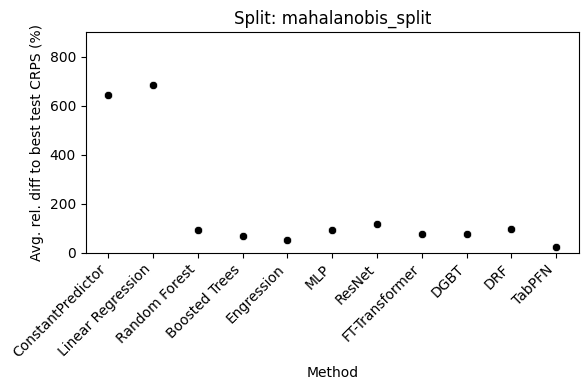

Split 'kmeans_split': baseline CRPS per task:
 task_id
361072    2.110439
361073    0.689861
361074    0.001096
361076    0.367232
361077    0.000114
361078    0.112608
361079    0.283992
361080    0.143850
361081    0.018200
361082    0.291423
361083    0.230019
361084    0.090500
361085    0.014248
361086    0.104729
361087    0.098760
361088    0.709287
361279    0.014390
361280    1.069203
361281    1.666730
dtype: float64
Split 'kmeans_split': overall lowest CRPS = 0.0001144435324687



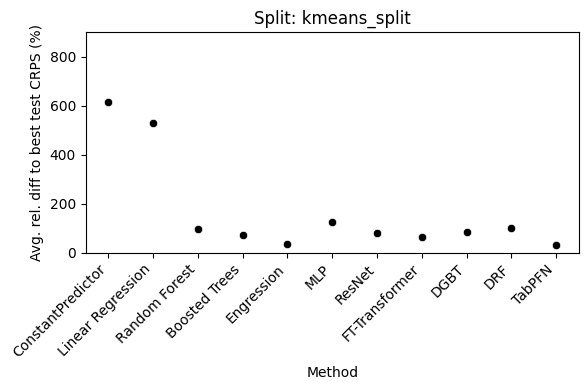

Split 'spatial_depth_split': baseline CRPS per task:
 task_id
361072    2.571273
361073    0.445553
361074    0.001253
361076    0.392900
361077    0.000113
361078    0.125056
361079    0.381051
361080    0.157022
361081    0.012783
361082    0.395713
361083    0.217773
361085    0.017773
361086    0.094031
361087    0.148811
361088    0.595162
361279    0.014535
361280    1.157940
361281    1.682539
dtype: float64
Split 'spatial_depth_split': overall lowest CRPS = 0.0001129965516914



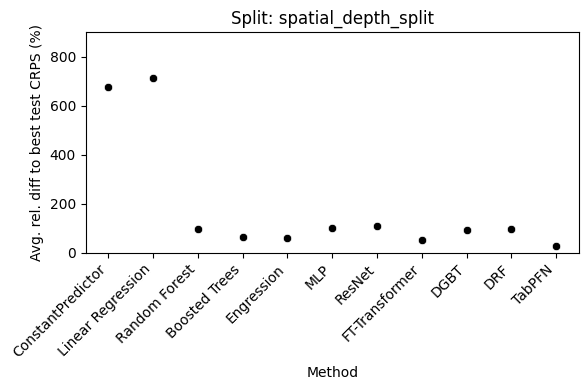

In [5]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    print(f"Split '{split}': baseline CRPS per task:\n", baseline)
    print(f"Split '{split}': overall lowest CRPS = {baseline.min()}\n")

    rel = (table - baseline) / baseline

    summary = pd.DataFrame({
        "Mean": rel.mean(axis=1),
        "Median": rel.median(axis=1),
        "Std": rel.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Avg. rel. diff to best test CRPS (%)")
    plt.title(f"Split: {split}")
    plt.ylim(0, 900)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    fname = f"{split}_relative_diff_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()




In [6]:
df = df[df["metric"] == "CRPS"]
df = df[df["value"] >= 0].copy()


df = df[df["split_method"] != "random_split"]


=== RAW relative_difference sample ===
       split_method  task_id              model       value  baseline  \
506     gower_split   361093                DRF    0.334312  0.021535   
507     gower_split   361093               DGBT    0.024720  0.021535   
508  kmedoids_split   361093                DRF    0.316729  0.024336   
509  kmedoids_split   361093               DGBT    0.024336  0.024336   
510      umap_split   361093                DRF    0.811470  0.183040   
511      umap_split   361093               DGBT    0.422174  0.183040   
517      umap_split   361093    LinearRegressor    0.674186  0.183040   
519      umap_split   361093  ConstantPredictor    0.800697  0.183040   
521  kmedoids_split   361093    LinearRegressor    0.256131  0.024336   
523  kmedoids_split   361093  ConstantPredictor    0.341237  0.024336   
525     gower_split   361093    LinearRegressor    0.313598  0.021535   
527     gower_split   361093  ConstantPredictor    0.370604  0.021535   
537     gow

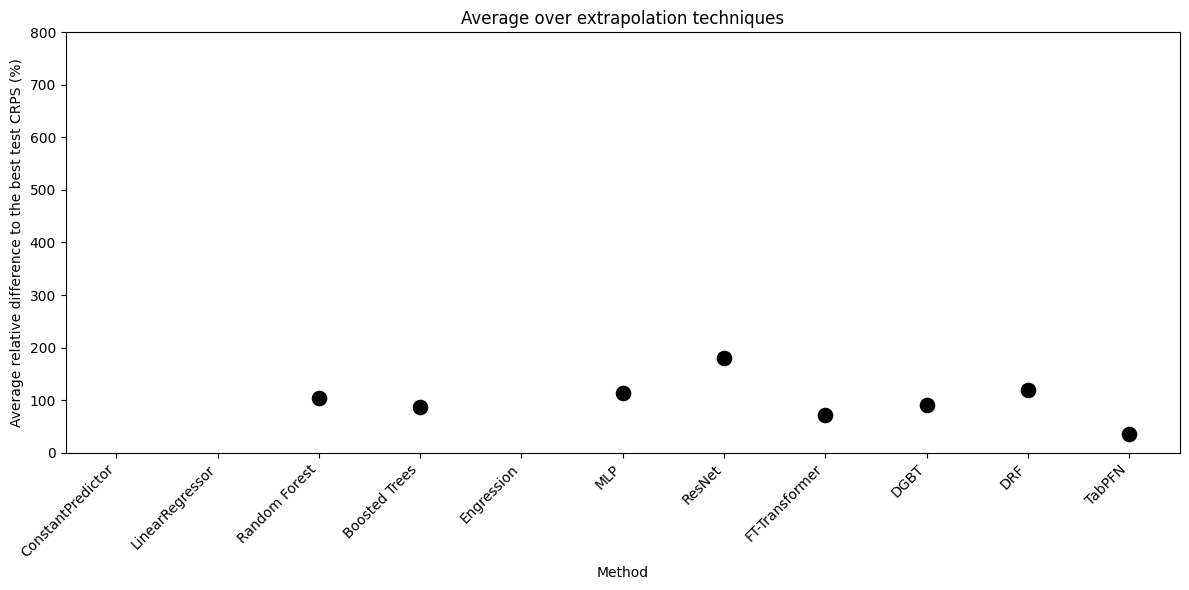

In [7]:
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

df["relative_difference"] = (df["value"] - df["baseline"]) / df["baseline"]

print("\n=== RAW relative_difference sample ===")
print(df[['split_method','task_id','model','value','baseline','relative_difference']].head(20))

print("\n=== per-model relative_difference summary ===")
print(df.groupby('model')['relative_difference']
        .agg(count='count', mean='mean', min='min', max='max')
        .sort_values('mean', ascending=False)
     )

print("\n=== model appearance counts ===")
print(df.groupby('model')['relative_difference']
        .count()
        .sort_values(ascending=False)
     )

overall = (
    df
    .groupby('model')['relative_difference']
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100  # to percent

method_order = [
    'ConstantPredictor', 'LinearRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestRegressor':'Random Forest',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'DGBT':                 'DGBT',
    'DRF':                  'DRF',
    'TabPFNRegressor':      'TabPFN'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average relative difference to the best test CRPS (%)')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques')
plt.ylim(0, 800)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_over_extrapolation_techniques_CRPS.png', bbox_inches='tight')
plt.show()
